## *Legend of the Five Rings* (up to 4th edition)

In this system you roll a number of exploding d10s (i.e. if you roll a 10, you roll it again and add it to the running total, as long as you keep rolling 10s). Then you keep a number of the highest among them and sum.

This is an infamous challenge for dice calculators.

### AnyDice

[AnyDice](https://anydice.com/) appears to take exponential time in the number of dice. For example,

```
output [highest 5 of 10d[explode d10]]
```

times out. (n.b. At default, AnyDice explodes dice up to two times, not counting the base roll.)

### Troll

The [conference paper](http://hjemmesider.diku.dk/~torbenm/Troll/Troll-SAC.pdf) for the [Troll dice roller and probability calculator](https://topps.diku.dk/torbenm/troll.msp) says:

> For example, the game "Legend of Five Rings" uses a roll mechanism that can be described in Troll as
>
> ``` sum (largest M N#(sum accumulate x := d10 until x<10)) ```
>
> where M and N depend on the situation. With M = 3, N = 5 and the maximum number of iterations for accumulate set to 5, Troll takes nearly 500 seconds to calculate the result, and it gets much worse if any of the numbers increase.

To be fair, this paper was presented more than a decade ago, and hardware has advanced considerably since then. [cpubenchmark.net](https://www.cpubenchmark.net/compare/Intel-Pentium-4-3.20GHz-vs-Intel-i5-8400/1076vs3097) shows a factor of about 5× in single-threaded performance and 33× in overall performance from the CPU used in the paper to my current desktop CPU. However, 500 seconds is a long time, and even this advancement in hardware is not nearly enough to overcome even modest increases in the number of dice due to the exponential time of the algorithm.

### SnakeEyes

A Lua-language calculator that runs locally in the browser. (Hence why I don't feel bad linking [a futile *L5R* script](https://snake-eyes.io/?script=DYVgTgBAvBAmCMAGAXAUwB4AdgHtaoAokAaCAZgEoAoK7HAFwKMQgCoJQwLlYwdMA+rgDuqAM6MQFCkA) in this case, as it's not putting load on someone else's server. I don't recommend clicking on that if your computer is prone to hanging though.) The author did come up with an [optimized script](https://snake-eyes.io/?url=examples/l5r.lua) for *L5R* in particular, though this still takes some time especially as the explosion depth increases.

### lynks.se

There does exist a website with *L5R* probabilities: [lynks.se](https://lynks.se/probability/). However, if you look at that webpage's source code, you'll see that the probabilities have been precomputed and stored in static arrays. Furthermore, there is a small but noticeable amount of noise in the data, indicating that it was computed via Monte Carlo rather than a closed-form method.

Now let's give `hdroller` a try. First, import it:

In [1]:
try:
    # JupyterLite
    import micropip
    await micropip.install('hdroller')
except ModuleNotFoundError:
    # Jupyter
    import sys
    !{sys.executable} -m pip install hdroller

import hdroller
import time

Now run it. We'll give it a generous explosion limit of 9.

Notes:

* Internal computations will be cached, so subsequent runs will run faster. Restart the kernel for a more "fair" comparison.
* JupyterLite runs the computation right in your own browser, not an external server.

Computation time: 103 ms


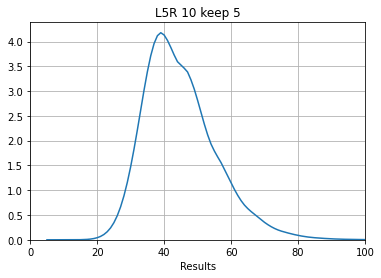

In [2]:
start_ns = time.perf_counter_ns()
result = hdroller.d10.explode(max_depth=9).keep_highest(10, 5)
end_ns = time.perf_counter_ns()
elapsed_ms = round((end_ns - start_ns) * 1e-6)
print(f'Computation time: {elapsed_ms} ms')

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(result.outcomes(), result.pmf(percent=True))
ax.set_title('L5R 10 keep 5')
ax.set_xlabel('Outcome')
ax.set_xlim(0, 100)
ax.set_ylim(0)
ax.grid(True)
plt.show()